<a href="https://colab.research.google.com/github/vishnu7411/facial_expression_recognition/blob/main/facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages (if needed)
!pip install numpy pandas matplotlib opencv-python tensorflow

In [2]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models


In [3]:
!unzip -q fer2013.zip

In [4]:
# 1. Verify folder structure
import os
print("Current working dir:", os.getcwd())
print("Top-level files and folders:", os.listdir())

# Check train and test exist and list their contents
if os.path.exists("train"):
    print("\nTrain subfolders:", sorted(os.listdir("train")))
else:
    print("\nNo 'train' folder found in working directory.")

if os.path.exists("test"):
    print("\nTest subfolders:", sorted(os.listdir("test")))
else:
    print("\nNo 'test' folder found in working directory.")


Current working dir: /content
Top-level files and folders: ['.config', 'fer2013.zip', 'test', 'train', 'sample_data']

Train subfolders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Test subfolders: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
# Count how many images are in each class (both train and test)

from collections import Counter
import os

# Function to count images in each subfolder (emotion class)
def count_images_in(dir_path):
    counts = {}
    for cls in sorted(os.listdir(dir_path)):  # Loop over each class folder
        cls_path = os.path.join(dir_path, cls)  # Full path to the class folder
        if os.path.isdir(cls_path):  # Ensure it's a folder (not a file)
            counts[cls] = len(os.listdir(cls_path))  # Count files in the folder
    return counts

# Count for training dataset
print("Train counts:")
print(count_images_in("train"))

# Count for testing dataset
print("\nTest counts:")
print(count_images_in("test"))


Train counts:
{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}

Test counts:
{'angry': 958, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


In [6]:
# Load train, validation, and test datasets

import tensorflow as tf
from tensorflow.keras import layers

# Settings
IMG_SIZE = (48, 48)   # Resize all images to 48x48
BATCH_SIZE = 32       # How many images to process at once
SEED = 123            # For reproducibility

train_dir = "train"
test_dir = "test"

# Load the training set (with 10% of it reserved for validation)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',             # Automatically use folder names as labels
    label_mode='categorical',      # One-hot encoded labels
    validation_split=0.1,          # Use 10% of data for validation
    subset='training',             # This is the training subset
    seed=SEED,
    image_size=IMG_SIZE,           # Resize images
    batch_size=BATCH_SIZE
)

# Load the validation set (remaining 10% of training data)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.1,
    subset='validation',           # This is the validation subset
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load the test set (entire folder is used)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False                   # Don't shuffle for test set
)

# Save the emotion names (class names)
class_names = train_ds.class_names

# Print confirmation
print("Class names:", class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Found 28709 files belonging to 7 classes.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train batches: 808
Val batches: 90
Test batches: 225


In [7]:
# Normalize and prefetch datasets

# Create a normalization layer that scales pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)

# Apply normalization + caching + prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(AUTOTUNE)

print("✅ Datasets normalized and performance optimized.")


✅ Datasets normalized and performance optimized.


In [8]:
# Create data augmentation layer

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),   # Flip images horizontally
    layers.RandomRotation(0.08),       # Rotate slightly
    layers.RandomZoom(0.08),           # Zoom in/out slightly
])

print("✅ Data augmentation layer created.")


✅ Data augmentation layer created.


In [9]:
# Build CNN model for Facial Expression Recognition

from tensorflow.keras import models

num_classes = len(class_names)  # 7 emotions

model = models.Sequential([
    layers.Input(shape=(48, 48, 3)),      # Input layer
    data_augmentation,                    # Data augmentation layer

    # Convolutional layers
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.BatchNormalization(),          # Normalize activations

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),                   # Prevent overfitting
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

# Show model architecture
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,615 (2.61 MB)

 Trainable params: 684,359 (2.61 MB)

 Non-trainable params: 256 (1.00 KB)

In [10]:
# Compile the model

model.compile(
    optimizer='adam',                          # Adam optimizer
    loss='categorical_crossentropy',           # Multi-class loss
    metrics=['accuracy']                       # Track accuracy
)

print("✅ Model compiled successfully.")


✅ Model compiled successfully.


In [11]:
# Train the model

EPOCHS = 40

history = model.fit(
    train_ds,                   # Training dataset
    validation_data=val_ds,     # Validation dataset
    epochs=EPOCHS
)

print("✅ Training complete.")


Epoch 1/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 106s 128ms/step - accuracy: 0.2548 - loss: 1.8405 - val_accuracy: 0.3125 - val_loss: 1.7125
Epoch 2/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 94s 116ms/step - accuracy: 0.3590 - loss: 1.6439 - val_accuracy: 0.3463 - val_loss: 2.1048
Epoch 3/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 94s 117ms/step - accuracy: 0.4011 - loss: 1.5562 - val_accuracy: 0.4132 - val_loss: 1.4846
Epoch 4/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 94s 116ms/step - accuracy: 0.4219 - loss: 1.5033 - val_accuracy: 0.4143 - val_loss: 1.5277
Epoch 5/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 93s 115ms/step - accuracy: 0.4394 - loss: 1.4695 - val_accuracy: 0.4840 - val_loss: 1.3684
Epoch 6/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 92s 114ms/step - accuracy: 0.4473 - loss: 1.4365 - val_accuracy: 0.4199 - val_loss: 1.5907
Epoch 7/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 91s 113ms/step - accuracy: 0.4574 - loss: 1.4243 - val_accuracy: 0.5021 - val_loss: 1.3388
Epoch 8/40
808/808 ━━━━━━━━━━━━━━━━━━━━ 142s 114ms/step - accuracy: 0.4595 - loss:

In [12]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4895 - loss: 1.3095
✅ Test Accuracy: 0.5450
✅ Test Loss: 1.1975


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


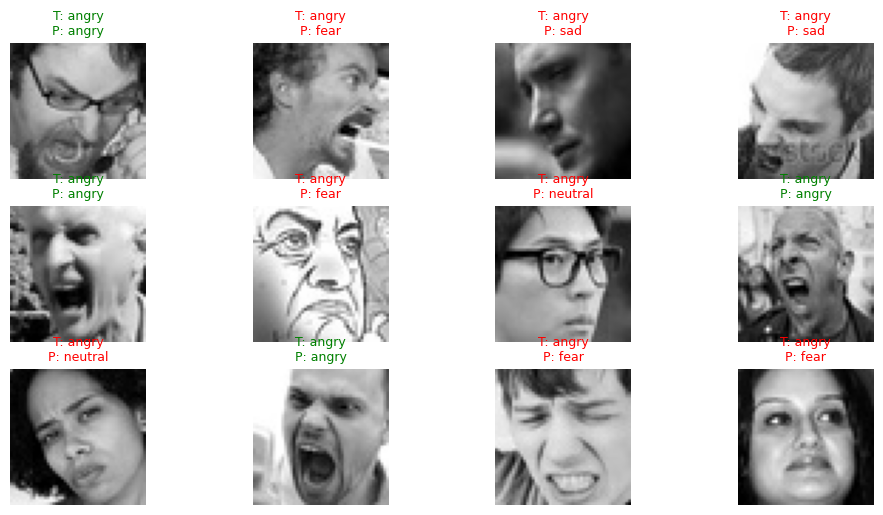

In [13]:
# Visualize predictions (fixed version)

import matplotlib.pyplot as plt
import numpy as np

# Define class names manually (we know the order from earlier)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Take one batch from the test dataset
for images, labels in test_ds.take(1):
    preds = model.predict(images)  # Model predictions
    pred_labels = np.argmax(preds, axis=1)  # Convert probabilities → class index
    true_labels = np.argmax(labels.numpy(), axis=1)  # True labels

    plt.figure(figsize=(12, 6))
    for i in range(12):  # Show first 12 images
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy())
        true_class = class_names[true_labels[i]]
        pred_class = class_names[pred_labels[i]]
        color = "green" if true_class == pred_class else "red"
        plt.title(f"T: {true_class}\nP: {pred_class}", color=color, fontsize=9)
        plt.axis("off")
    plt.show()


In [14]:
# Import VGG16 and set up base model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load VGG16 without top classification layer
base_model = VGG16(
    weights='imagenet',          # Pretrained on ImageNet
    include_top=False,           # Remove the fully connected layers
    input_shape=(48, 48, 3)      # Our image size (we already resized earlier)
)

# Freeze base model layers
base_model.trainable = False

print("✅ VGG16 base model loaded and frozen.")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ VGG16 base model loaded and frozen.


In [15]:
# Add custom layers on top of VGG16

# Create new model
model_vgg16 = models.Sequential([
    base_model,                                      # Pretrained VGG16 base
    layers.Flatten(),                                # Flatten feature maps
    layers.Dense(256, activation='relu'),            # Dense layer for learning patterns
    layers.Dropout(0.5),                             # Dropout for regularization
    layers.Dense(7, activation='softmax')            # Output layer (7 classes)
])

# Compile the model
model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show the model summary
model_vgg16.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Train the VGG16-based model
history_vgg16 = model_vgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # Start with 10 epochs; we can fine-tune later
)


Epoch 1/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 545s 673ms/step - accuracy: 0.3033 - loss: 1.7505 - val_accuracy: 0.3739 - val_loss: 1.5882
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 529s 632ms/step - accuracy: 0.3743 - loss: 1.6036 - val_accuracy: 0.3895 - val_loss: 1.5583
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 510s 632ms/step - accuracy: 0.3933 - loss: 1.5683 - val_accuracy: 0.3916 - val_loss: 1.5441
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 509s 630ms/step - accuracy: 0.3991 - loss: 1.5459 - val_accuracy: 0.3997 - val_loss: 1.5315
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 540s 669ms/step - accuracy: 0.4083 - loss: 1.5276 - val_accuracy: 0.4080 - val_loss: 1.5098
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 538s 639ms/step - accuracy: 0.4163 - loss: 1.5089 - val_accuracy: 0.4042 - val_loss: 1.5141
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 508s 629ms/step - accuracy: 0.4267 - loss: 1.4960 - val_accuracy: 0.4059 - val_loss: 1.5096
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 512s 633ms/step - accuracy: 0.4275 -

In [17]:
# Fine-tuning VGG16
# Unfreeze the last 4 layers of the base model
for layer in model_vgg16.layers[0].layers[-4:]:
    layer.trainable = True

# Recompile with a smaller learning rate to avoid destroying pre-trained weights
from tensorflow.keras.optimizers import Adam
model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train again for more epochs
history_vgg16_ft = model_vgg16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - accuracy: 0.4567 - loss: 1.4205 - val_accuracy: 0.4725 - val_loss: 1.3909
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 883s 1s/step - accuracy: 0.5072 - loss: 1.2955 - val_accuracy: 0.4902 - val_loss: 1.3585
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 867s 1s/step - accuracy: 0.5376 - loss: 1.2124 - val_accuracy: 0.4986 - val_loss: 1.3344
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 974s 1s/step - accuracy: 0.5810 - loss: 1.1235 - val_accuracy: 0.5150 - val_loss: 1.3089
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 889s 1s/step - accuracy: 0.6015 - loss: 1.0503 - val_accuracy: 0.5254 - val_loss: 1.2970
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 856s 1s/step - accuracy: 0.6331 - loss: 0.9926 - val_accuracy: 0.5334 - val_loss: 1.2895
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 855s 1s/step - accuracy: 0.6559 - loss: 0.9260 - val_accuracy: 0.5352 - val_loss: 1.2814
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 847s 1s/step - accuracy: 0.6811 - loss: 0.8630 - val_accu

Epoch 1/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 887s 1s/step - accuracy: 0.2363 - loss: 2.2089 - val_accuracy: 0.3993 - val_loss: 1.9077
Epoch 2/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 919s 1s/step - accuracy: 0.3338 - loss: 1.9924 - val_accuracy: 0.4355 - val_loss: 1.7940
Epoch 3/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 847s 1s/step - accuracy: 0.3640 - loss: 1.9185 - val_accuracy: 0.4449 - val_loss: 1.7312
Epoch 4/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 901s 1s/step - accuracy: 0.3770 - loss: 1.8637 - val_accuracy: 0.4512 - val_loss: 1.6886
Epoch 5/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 873s 1s/step - accuracy: 0.3867 - loss: 1.8206 - val_accuracy: 0.4596 - val_loss: 1.6416
Epoch 6/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 918s 1s/step - accuracy: 0.3963 - loss: 1.7881 - val_accuracy: 0.4662 - val_loss: 1.6293
Epoch 7/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 917s 1s/step - accuracy: 0.4040 - loss: 1.7475 - val_accuracy: 0.4763 - val_loss: 1.5840
Epoch 8/30
808/808 ━━━━━━━━━━━━━━━━━━━━ 845s 1s/step - accuracy: 0.4061 - loss: 1.7199 - val_accu

<Figure size 800x600 with 0 Axes>

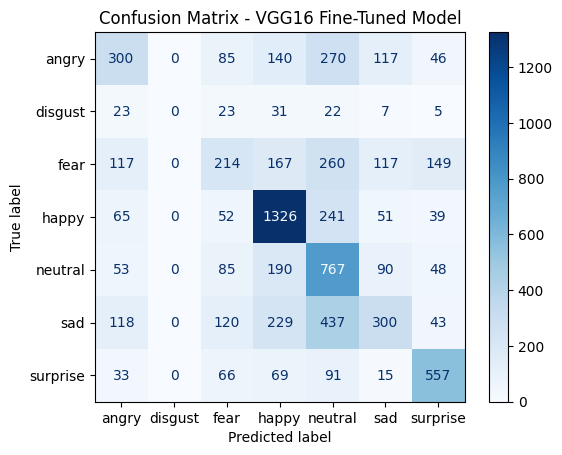

In [18]:
# Fine-tuning VGG16 with Overfitting Control + Evaluation

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1️⃣ Data augmentation (more aggressive to prevent overfitting)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1)
])

# 2️⃣ Rebuild model with dropout + L2 regularization
model_vgg16_aug = tf.keras.Sequential([
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

# Unfreeze last 4 conv layers for fine-tuning
for layer in model_vgg16_aug.layers[1].layers[-4:]:
    layer.trainable = True

# 3️⃣ Compile with low learning rate for fine-tuning
model_vgg16_aug.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4️⃣ Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 5️⃣ Train
history_vgg16_aug = model_vgg16_aug.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

# 6️⃣ Evaluate on test set
test_loss, test_acc = model_vgg16_aug.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {test_acc:.4f}")
print(f"✅ Final Test Loss: {test_loss:.4f}")

# 7️⃣ Confusion Matrix
# Get predictions and true labels
y_true = []
y_pred = []
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

for images, labels in test_ds:
    preds = model_vgg16_aug.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - VGG16 Fine-Tuned Model")
plt.show()


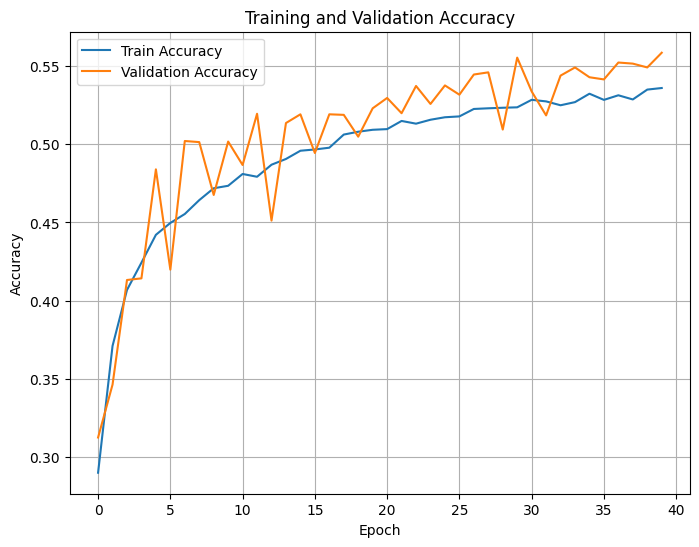

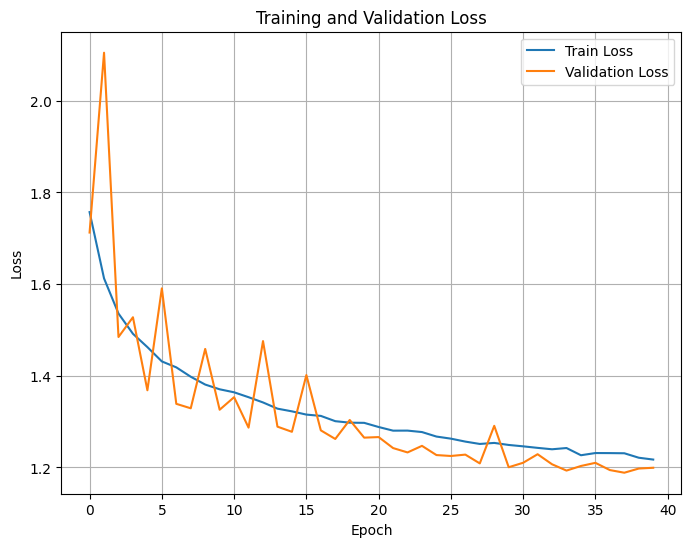

In [19]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
